In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
import re
import os 


In [2]:
# ------------------------------------------------------
# 1) Load Data
# ------------------------------------------------------
parent_dir = os.path.abspath("..")
dataset_dir = os.path.join(parent_dir, "Dataset/TMDB_movie_dataset_v11.csv")
df = pd.read_csv(dataset_dir, parse_dates=['release_date'], low_memory=False)
print(df.head())

       id            title  vote_average  vote_count    status release_date  \
0   27205        Inception         8.364       34495  Released   2010-07-15   
1  157336     Interstellar         8.417       32571  Released   2014-11-05   
2     155  The Dark Knight         8.512       30619  Released   2008-07-16   
3   19995           Avatar         7.573       29815  Released   2009-12-15   
4   24428     The Avengers         7.710       29166  Released   2012-04-25   

      revenue  runtime  adult                     backdrop_path  ...  \
0   825532764      148  False  /8ZTVqvKDQ8emSGUEMjsS4yHAwrp.jpg  ...   
1   701729206      169  False  /pbrkL804c8yAv3zBZR4QPEafpAR.jpg  ...   
2  1004558444      152  False  /nMKdUUepR0i5zn0y1T4CsSB5chy.jpg  ...   
3  2923706026      162  False  /vL5LR6WdxWPjLPFRLe133jXWsh5.jpg  ...   
4  1518815515      143  False  /9BBTo63ANSmhC4e6r62OJFuK2GL.jpg  ...   

    original_title                                           overview  \
0        Inception 

In [3]:
df = df.dropna(subset=['release_date', 'title'])

# Convert release_date to year, filter out invalid years
df['release_year'] = df['release_date'].dt.year.astype(int)
df = df[(df['release_year'] >= 1920) & (df['release_year'] <= 2025)]

Distribution of Ratings

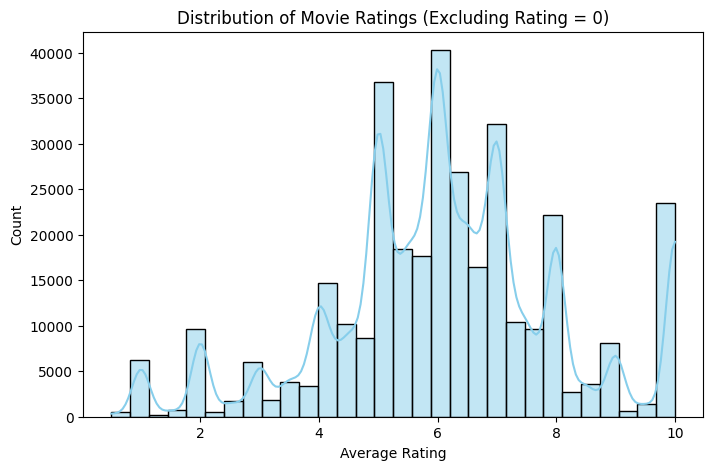

In [4]:
df_valid_ratings = df[df['vote_average'] > 0]

plt.figure(figsize=(8,5))
sns.histplot(df_valid_ratings['vote_average'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Movie Ratings (Excluding Rating = 0)')
plt.xlabel('Average Rating')
plt.ylabel('Count')
plt.show()

Observation
The distribution is slightly skewed around 4-8 with a peak near 6.

<Figure size 1200x600 with 0 Axes>

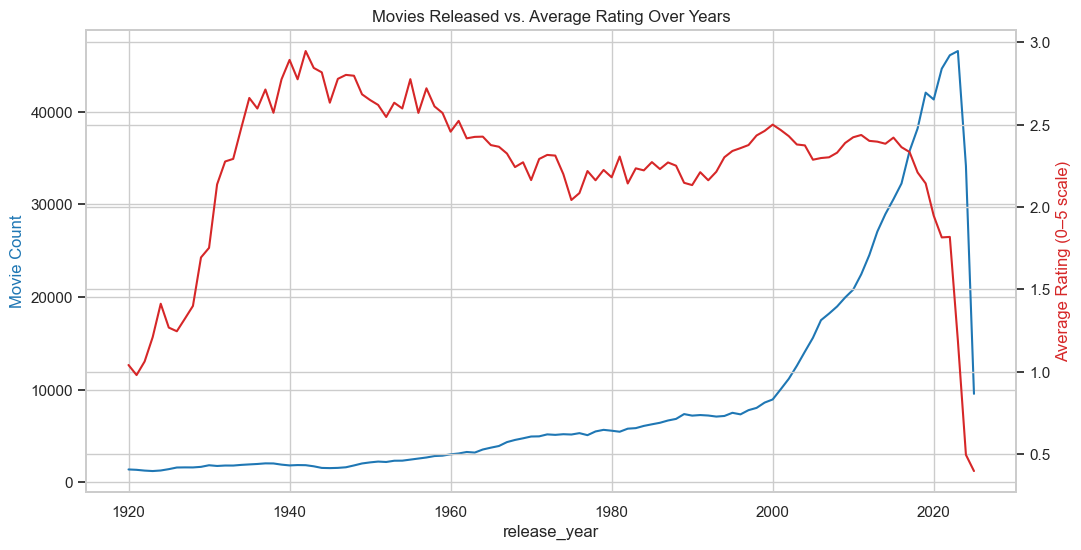

In [5]:
# 2. Production & Rating Trends
year_stats = df.groupby('release_year').agg(
    movie_count=('title', 'count'),
    avg_rating=('vote_average', 'mean')
).reset_index()

year_stats = year_stats[(year_stats['movie_count'] >= 50) & (year_stats['release_year'] <= 2025)]

plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
fig, ax1 = plt.subplots(figsize=(12, 6))
sns.lineplot(data=year_stats, x='release_year', y='movie_count', color='tab:blue', ax=ax1)
ax1.set_ylabel('Movie Count', color='tab:blue')

ax2 = ax1.twinx()
sns.lineplot(data=year_stats, x='release_year', y='avg_rating', color='tab:red', ax=ax2)
ax2.set_ylabel('Average Rating (0–5 scale)', color='tab:red')
plt.title('Movies Released vs. Average Rating Over Years')
plt.show()

📈 Observation
The graph reveals a consistent upward trend in the number of movies released each year (blue line), with a particularly sharp acceleration beginning around 1980 and peaking near 2020.
In contrast, the average movie rating (red line) remains relatively stable throughout most of the observed period. However, ratings before the 1940s show significant volatility, likely due to a smaller and less consistent volume of available data from early cinema history.

After 2020, a noticeable dip in average ratings is observed, which is likely attributable to incomplete or provisional rating data for more recently released films.

Overall, the data suggests that while the quantity of movies produced has dramatically increased over time, the quality—as measured by audience ratings—has remained relatively constant, without a clear trend of substantial improvement or decline.

Top 15 genres:
 genre_list
Drama              215817
Documentary        159182
Comedy             132598
Animation           56331
Romance             51270
Horror              50341
Music               48241
Thriller            43686
Action              42787
Crime               32300
Family              27201
TV Movie            23566
Adventure           22484
Fantasy             21834
Science Fiction     20070
Name: count, dtype: int64




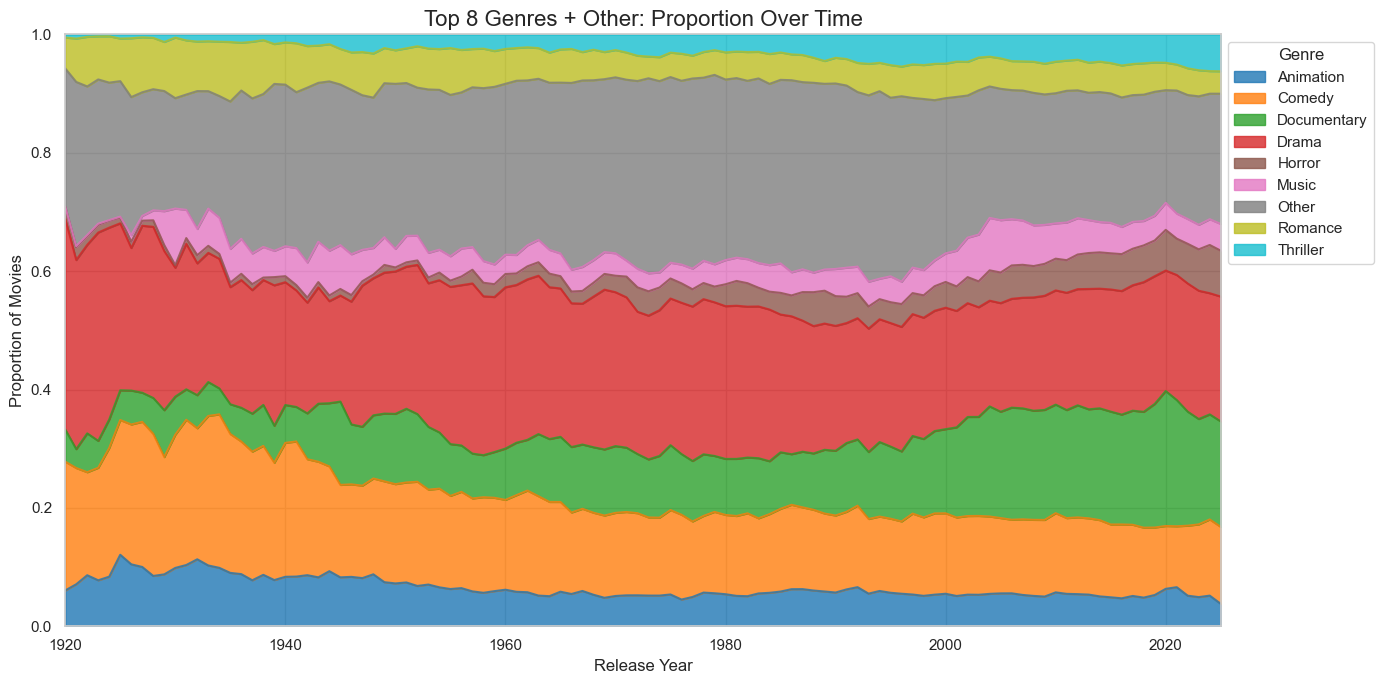

In [6]:
# 3. Genre Evolution
df['genre_list'] = (
    df['genres']
    .fillna('')
    .str.split(',')
    .apply(lambda lst: [g.strip() for g in lst if g.strip() != ''])
)
df_exp = df.explode('genre_list')
df_exp = df_exp[df_exp['genre_list'].notna() & (df_exp['genre_list'] != '')]
print("Top 15 genres:\n", df_exp['genre_list'].value_counts().head(15))
print("\n")

top8 = df_exp['genre_list'].value_counts().nlargest(8).index.tolist()
df_exp['genre_top'] = df_exp['genre_list'].where(
    df_exp['genre_list'].isin(top8),
    other='Other'
)

grp = df_exp.groupby(['release_year', 'genre_top']).size().reset_index(name='count')
pivot = grp.pivot(index='release_year', columns='genre_top', values='count').fillna(0)
prop = pivot.div(pivot.sum(axis=1), axis=0).sort_index()

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(14, 7))
prop.plot.area(ax=ax, cmap='tab10', alpha=0.8)

ax.set_xlim(prop.index.min(), prop.index.max())
ax.set_ylim(0, 1)
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), title='Genre')
ax.set_title('Top 8 Genres + Other: Proportion Over Time', fontsize=16)
ax.set_xlabel('Release Year', fontsize=12)
ax.set_ylabel('Proportion of Movies', fontsize=12)
plt.tight_layout()
plt.show()

🎬 Observation
This stacked area chart illustrates the evolving distribution of movie genres from 1900 to 2020.
Drama has consistently dominated across the decades, maintaining a significant share of the film industry. Comedy and documentary genres also show steady contributions, though with noticeable fluctuations—documentaries, in particular, declined during the mid-1900s before experiencing a resurgence in the 2000s.

Starting in the 1970s, horror and music genres gained greater prominence. Romance, by contrast, has remained relatively stable over time.
The growing size of the "Other" category suggests either an expansion of niche genres or more inconsistent genre labeling in recent years.

Overall, the chart highlights how audience preferences and industry dynamics have shaped the changing landscape of movie genres over the last century.

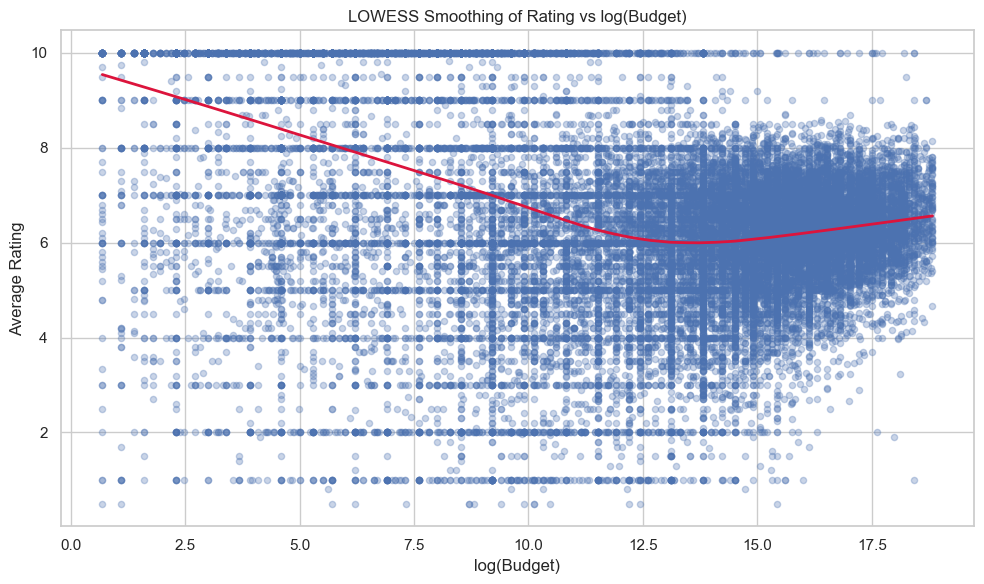

In [7]:
# 4. Budget vs Rating
df['budget'] = pd.to_numeric(df['budget'], errors='coerce')
df_budget = df[(df['budget'] > 0) & (df['vote_average'].notna()) & (df['vote_average'] > 0)]

low, high = df_budget['budget'].quantile([0.01, 0.99])
df_budget = df_budget[(df_budget['budget'] >= low) & (df_budget['budget'] <= high)]

df['log_budget'] = np.log(df_budget['budget'])
mask = np.isfinite(df['log_budget']) & np.isfinite(df['vote_average'])
df_clean = df.loc[mask, ['log_budget', 'vote_average']]

plt.figure(figsize=(10,6))
sns.regplot(
    data=df_clean,
    x='log_budget',
    y='vote_average',
    scatter_kws={'alpha':0.3, 's':20},
    line_kws={'color':'crimson', 'lw':2},
    lowess=True
)
plt.title('LOWESS Smoothing of Rating vs log(Budget)')
plt.xlabel('log(Budget)')
plt.ylabel('Average Rating')
plt.tight_layout()
plt.show()

Observation:
This scatter plot examines the relationship between a movie’s log-transformed budget and its average rating, with a LOWESS smoothing curve shown in red. The distribution highlights a dense cluster of low-budget films spanning a wide range of ratings, whereas higher-budget films are more narrowly concentrated between ratings 5 and 8.

The LOWESS trendline reveals an initial decline in average ratings as budgets increase from low to mid levels, suggesting that spending more does not always translate into better audience reception. However, at the very high-budget range, there is a modest upward trend, implying that exceptionally large budgets may slightly improve reception — although the effect is not dramatic.

Overall, the plot suggests that mid-range budgets often produce some of the highest-rated films, and that extremely large budgets do not guarantee significantly better ratings, highlighting the complex relationship between financial investment and audience appreciation.

Revenue Prediciton EDA Analysis